In [ ]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

# %load_ext autoreload
# %autoreload 2

In [2]:
data = np.load("processed_data.npz")

In [3]:
data.files


['x_train', 'y_train', 'x_test', 'y_test']

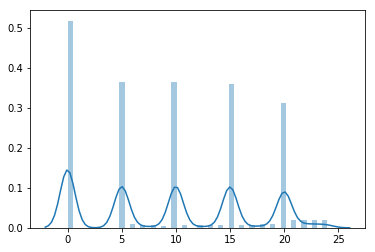

In [4]:
sns.distplot(data['x_train'][:,46:47])

In [5]:
data_path = "../cs238_sepsis_rl/data/"
final_df_train = pd.read_csv(data_path + 'train_state_action_reward_df.csv')
final_df_test = pd.read_csv(data_path+ 'test_state_action_reward_df.csv')

In [6]:
data['x_train'].shape

(153582, 47)

In [19]:
def term(df):
    if df.reward == 0:
        return "continue"
    if df.reward == 15:
        return "released"
    if df.reward == -15:
        return "died"
    
labels_train = final_df_train[['reward']].apply(term, axis=1).values.reshape(-1, 1)
labels_test = final_df_test[['reward']].apply(term, axis=1).values.reshape(-1, 1)


enc = OneHotEncoder()
enc.fit(labels_train)

labels_train_one_hot = enc.transform(labels_train)
labels_test_one_hot = enc.transform(labels_test)

In [9]:
enc.categories_

[array(['continue', 'died', 'released'], dtype=object)]

In [10]:
labels_train_one_hot.shape

(153582, 3)

In [11]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    labels_episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [12]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [13]:
test_matrix = get_padded_matrix( data['x_test'],  data['y_test'])

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                19600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 26,515
Trainable params: 26,515
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
labels_train_one_hot.shape

(153582, 3)

In [20]:
labels_test_one_hot.shape

(39232, 3)

In [22]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/mortality{}".format(time()))
model.fit(train_matrix, labels_train_one_hot, epochs=10, batch_size=1000, validation_data=(test_matrix, labels_test_one_hot), callbacks=[tensorboard])


Train on 153582 samples, validate on 39232 samples
Epoch 1/10
153582/153582 [==============================] - 13s 85us/step - loss: 0.3749 - acc: 0.8948 - val_loss: 0.2774 - val_acc: 0.9128
Epoch 2/10
153582/153582 [==============================] - 13s 83us/step - loss: 0.2717 - acc: 0.9109 - val_loss: 0.2616 - val_acc: 0.9132
Epoch 3/10
153582/153582 [==============================] - 13s 83us/step - loss: 0.2619 - acc: 0.9112 - val_loss: 0.2565 - val_acc: 0.9136
Epoch 4/10
153582/153582 [==============================] - 14s 93us/step - loss: 0.2569 - acc: 0.9118 - val_loss: 0.2531 - val_acc: 0.9132
Epoch 5/10
153582/153582 [==============================] - 13s 85us/step - loss: 0.2534 - acc: 0.9118 - val_loss: 0.2524 - val_acc: 0.9132
Epoch 6/10
153582/153582 [==============================] - 13s 83us/step - loss: 0.2502 - acc: 0.9122 - val_loss: 0.2514 - val_acc: 0.9122
Epoch 7/10
153582/153582 [==============================] - 14s 88us/step - loss: 0.2478 - acc: 0.9123 - val_

In [23]:
model.save("sepsis_mortality.model")